In [1]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from keras import layers

2024-08-13 19:36:24.821413: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-13 19:36:24.853946: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-13 19:36:25.317373: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Coletando dados

df = pd.read_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Peixes/Sciaenidae/RJ_Reconstrucao_Sciaenidae_2024_08_06.xlsx')
df_totais = pd.DataFrame(df[['Ano','TOTAL_FISHES_F&M','TOTAL_GROUPS_F&M']])

dados = df_totais.dropna().reset_index(drop=True)

#Fazendo as proporções de ostra_art em relação a mexilhao_art
for i in range(len(dados['Ano'])):
  dados.loc[i,'Prop_TOTAL_FISHES_F&M'] = dados.loc[i,'TOTAL_FISHES_F&M'] / dados.loc[i,'TOTAL_GROUPS_F&M']


anos_com_dados = dados["Ano"].values
anos_para_prever = np.array([1950,1951,1952,1953,1954,1955])
todos_anos = np.concatenate((anos_para_prever, anos_com_dados))
todos_anos.sort()


prop = dados['Prop_TOTAL_FISHES_F&M'].values
dados.head()

,Ano,TOTAL_FISHES_F&M,TOTAL_GROUPS_F&M,Prop_TOTAL_FISHES_F&M
0,1956,23181.0,24791.0,0.935057
1,1957,16429.0,17764.0,0.924848
2,1958,16654.0,18001.0,0.925171
3,1959,21356.0,23505.0,0.908573
4,1960,22101.0,32473.0,0.680596


In [3]:
#Normalização dos dados

ano_mean = np.mean(anos_com_dados)
ano_std = np.std(anos_com_dados)
anos_para_prever_norm = (anos_para_prever - ano_mean)/ano_std
anos_com_dados_norm = (anos_com_dados - ano_mean)/ano_std

prop_mean = np.mean(prop)
prop_std = np.std(prop)
prop_norm = (prop - prop_mean)/prop_std

In [4]:
#Fit do modelo e salvando seus pesos
model = keras.Sequential([layers.Dense(96,activation='leaky_relu',input_shape=(1,)),
                             layers.Dense(32,activation='leaky_relu'),
                             layers.Dense(80,activation='leaky_relu'),
                             layers.Dense(80,activation='leaky_relu'),
                             layers.Dense(96,activation='leaky_relu'),
                             layers.Dense(112,activation='leaky_relu'),
                             layers.Dense(1,activation='linear')])

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse')


#history = model.fit(anos_com_dados_norm,prop_norm, epochs=500, verbose=1)
#model.save_weights('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Peixes/TOTAL_FISHES/pesos TOTAL_FISHES_F&M/.weights.h5', overwrite=True)

/home/andre/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
model.load_weights('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Peixes/TOTAL_FISHES/pesos TOTAL_FISHES_F&M/.weights.h5')

/home/andre/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 31 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Previsões dos dados ausentes: [[0.88940203]
 [0.8819457 ]
 [0.8743132 ]
 [0.86632764]
 [0.8579118 ]
 [0.8484457 ]]


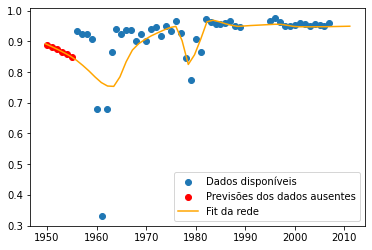

In [6]:
#Previsões
prev_disponiveis = model.predict(anos_com_dados_norm)*prop_std + prop_mean
prev_ausentes = model.predict(anos_para_prever_norm)*prop_std + prop_mean

#Colocando valores negativos para 0
for i in range(len(prev_ausentes)):
    if prev_ausentes[i]<0:
        prev_ausentes[i]=0
    if prev_ausentes[i]>=1:
        prev_ausentes[i]=1

#Plot dos dados e previsões
f1=plt.figure(1).add_subplot()
f1.scatter(anos_com_dados,prop,label='Dados disponíveis')
f1.scatter(anos_para_prever,prev_ausentes, color='red', label='Previsões dos dados ausentes')

#Plot do fit da rede
p = np.linspace(-2,2,50)
y = model.predict(p)*prop_std + prop_mean
f1.plot(p*ano_std + ano_mean,y,color='orange',label='Fit da rede')

#Print das previsões
print('Previsões dos dados ausentes:', prev_ausentes)


plt.legend()
plt.show()

In [7]:
loss = history.history['loss']
plt.plot(loss,label='loss')
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [8]:
#Planilha com dados preenchidos
df_preenchido = df[['Ano','TOTAL_FISHES_F&M','TOTAL_GROUPS_F&M']].iloc[:1956-1950,:].reset_index(drop=True)
for i in range(len(df_preenchido['Ano'])):
    df_preenchido.loc[i,'TOTAL_FISHES_F&M'] = df_preenchido.loc[i,'TOTAL_GROUPS_F&M']*prev_ausentes[i,:]

df_preenchido = df_preenchido[['Ano','TOTAL_FISHES_F&M']]

df_preenchido.to_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Peixes/TOTAL_FISHES/Previsão TOTAL_FISHES_F&M_1950-1955.xlsx')

df_preenchido

,Ano,TOTAL_FISHES_F&M
0,1950,25025.105469
1,1951,24193.535156
2,1952,23298.697266
3,1953,21270.076172
4,1954,19521.783203
5,1955,24013.558594
